### 多路召回
多路召回指的是采用不同的策略、特征或者简单模型，分别召回一部分候选集，然后把候选集混合在一起供后续排序模型使用。<br>
可以使用多种不同的策略来获取用户排序的候选商品集合，而具体使用的策略是和业务强相关的，针对不同的任务就会有对于该业务真实场景下需要考虑的召回规则。<br>
例如，新闻推荐的召回规则可以是“热门新闻”、“作者召回”、“关键词召回”、“主题召回”、“协同过滤召回”。

## 导包

In [50]:
conda install faiss

Channels:
 - rapidsai
 - nvidia
 - nodefaults
 - conda-forge
 - defaults
 - pytorch
Platform: linux-64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [106]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pickle
import math
import collections
from collections import defaultdict
import faiss
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

In [52]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/news-recommendation-dataset/articles.csv
/kaggle/input/news-recommendation-dataset/testA_click_log.csv
/kaggle/input/news-recommendation-dataset/train_click_log.csv
/kaggle/input/news-recommendation-dataset/articles_emb.csv
/kaggle/input/news-recommendation-dataset/sample_submit.csv


In [53]:
data_path='/kaggle/input/news-recommendation-dataset/'
save_path='/kaggle/working/'
metric_recall=False

## 读取数据
1. debug模式：基于数据搭建baseline并且跑通，可以在debug模式下从海量的数据集中随机抽取一部分样本（**train_click_log_sample**）来对baseline进行调试；
2. 线下验证模式：基于已有的训练集数据，来选择好合适的模型和一些超参数，因此这一块只需要加载整个训练集（**train_click_log**），然后将训练集分为训练集和验证集。（训练集是模型的训练数据，验证集部分帮助我们调整模型的参数和其他的一些超参数）
3. 线上模式：用debug模式搭建好一个推荐系统比赛的baseline，用线下验证模式选择好了模型和一些超参数，这一部分就是对于给定的测试集进行预测，提交到线上，所以这块使用的训练数据集是全量的数据集（**train_click_log+test_click_log**）

In [54]:
# debug模式：从训练集中划分一些数据来调试代码
def get_all_click_sample(data_path, sample_nums=10000):
    """
        从训练数据集中随机抽取一部分数据用于调试
        data_path：原数据的存储路径
        sample_nums：采样数目
    """
    all_click=pd.read_csv(data_path+'train_click_log.csv')
    all_user_ids=all_click.user_id.unique()
    
    # 随机抽取sample_nums个数据
    sample_user_ids=np.random.choice(all_user_ids,size=sample_nums,replace=False)
    # 获取sample_user_ids对应的在all_click中的数据
    all_click=all_click[all_click['user_id'].isin(sample_user_ids)]
    
    all_click=all_click.drop_duplicates((['user_id','click_article_id','click_timestamp']))
    return all_click

# 读取点击数据
def get_all_click_df(data_path,offline=True):
    """
        从给定的路径中读取点击数据，并根据offline参数决定是仅读取训练数据还是同时读取训练和测试数据
        data_path：原数据的存储路径
        offline：表示是否处于离线模式。在离线模式下，只处理训练数据，否则，同时处理训练和测试数据
    """
    if offline:
        all_click=pd.read_csv(data_path+'train_click_log.csv')
    else:
        trn_click=pd.read_csv(data_path+'train_click_log.csv')
        tst_click=pd.read_csv(data_path+'testA_click_log.csv')
        
        # 包含测试集和训练集
        all_click=pd.concat([trn_click,tst_click])
    
    # 去除重复的点击记录，保留唯一的(user_id, click_article_id, click_timestamp)组合
    all_click=all_click.drop_duplicates((['user_id','click_article_id','click_timestamp']))
    return all_click

In [55]:
# 读取文章的基本属性
def get_item_info_df(data_path):
    item_info_df=pd.read_csv(data_path+'articles.csv')
    
    # 为了与训练集中的click_article_id进行拼接，修改article_id为click_article_id
    item_info_df=item_info_df.rename(columns={'article_id':'click_article_id'})
    
    return item_info_df

In [56]:
# 读取文章的embedding属性
def get_item_emb_dict(data_path):
    item_emb_df=pd.read_csv(data_path+'articles_emb.csv')
    # 创建列表item_emb_cols，包含item_emb_df中所有列名包含'emb'的列（用于筛选出包含嵌入向量的列）
    item_emb_cols=[x for x in item_emb_df.columns if 'emb' in x]
    # 利用ascontiguousarray函数将筛选出的嵌入向量列转换为一个连续的Numpy数组item_emb_np
    item_emb_np=np.ascontiguousarray(item_emb_df[item_emb_cols])
    # 进行归一化
    item_emb_np=item_emb_np/np.linalg.norm(item_emb_np,axis=1,keepdims=True)
    
    # 创建字典，将item_emb_df中的article_id列的值作为字典的键，将对应的归一化嵌入向量作为字典的值
    item_emb_dict=dict(zip(item_emb_df['article_id'],item_emb_np))
    # 使用pickle库将item_emb_dict字典序列化并保存到文件中
    # wb表示以二进制写入模式打开文件
    pickle.dump(item_emb_dict,open(save_path+'item_content_emb.pkl','wb'))
    
    return item_emb_dict

In [57]:
max_min_scaler=lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

In [58]:
# 采样数据
all_click_df=get_all_click_sample(data_path)
all_click_df.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
171,199943,50823,1507029639296,4,1,17,1,24,2
172,199943,272143,1507029669296,4,1,17,1,24,2
181,199939,64329,1507030084265,4,1,17,1,5,2
182,199939,199198,1507030114265,4,1,17,1,5,2
193,199935,199198,1507030783076,4,4,20,1,25,2


In [59]:
# 全量训练集
all_click_df=get_all_click_df(data_path,offline=False)
all_click_df.shape

(1630633, 9)

In [85]:
# 在这次中我们使用debug模式，也就是使用采样数据
all_click_df=get_all_click_sample(data_path,500)
all_click_df.shape

(2771, 9)

In [62]:
item_info_df=get_item_info_df(data_path)
item_info_df.head()

,click_article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162


In [63]:
item_emb_dict=get_item_emb_dict(data_path)

## 工具函数

### 获取用户-文章-时间函数

In [64]:
# 根据时间获取用户点击的商品序列: {user1:{item1:time1, item2:time2,...}}
def get_user_item_time(click_df):
    
    click_df = click_df.sort_values('click_timestamp')
    
    def make_item_time_pair(df):
        return list(zip(df['click_article_id'], df['click_timestamp']))
    
    user_item_time_df = click_df.groupby('user_id')[['click_article_id', 'click_timestamp']].apply(lambda x: make_item_time_pair(x))\
                                                            .reset_index().rename(columns={0: 'item_time_list'})
    user_item_time_dict = dict(zip(user_item_time_df['user_id'], user_item_time_df['item_time_list']))
    
    return user_item_time_dict

In [65]:
get_user_item_time(all_click_df)

{133: [(74722, 1508208053069), (61452, 1508208083069)],
 154: [(209122, 1508207804520), (48074, 1508207834520)],
 335: [(50644, 1508204734350), (202056, 1508204764350)],
 532: [(65839, 1508202475195), (331116, 1508202505195)],
 553: [(50644, 1508202281180),
  (315104, 1508202644578),
  (183562, 1508202873535),
  (16797, 1508202903535)],
 765: [(36162, 1508199902510), (209122, 1508199932510)],
 926: [(50644, 1508198578204), (205824, 1508198608204)],
 1139: [(50644, 1508196727598), (30760, 1508196757598)],
 1199: [(237293, 1508197456941), (233578, 1508197486941)],
 1336: [(206571, 1508195586025), (284470, 1508195616025)],
 1646: [(70429, 1508191450846), (79851, 1508191480846)],
 1918: [(206415, 1508188300022), (181437, 1508188330022)],
 2068: [(159195, 1508188870922), (202320, 1508188900922)],
 2424: [(169107, 1508183472820), (62465, 1508183502820)],
 2478: [(233988, 1508183311218), (237385, 1508183341218)],
 2517: [(65560, 1508183130038),
  (42786, 1508183382504),
  (42675, 150818341250

### 获取文章-用户-时间函数

In [66]:
# 根据时间获取商品被点击的用户序列 {item1: {user1:time1, user2:time2, ...}}
def get_item_user_time_dict(click_df):
    def make_user_time_pair(df):
        return list(zip(df['user_id'], df['click_timestamp']))
    
    click_df = click_df.sort_values('click_timestamp')
    item_user_time_df = click_df.groupby('click_article_id')[['user_id', 'click_timestamp']].apply(lambda x: make_user_time_pair(x))\
                                                            .reset_index().rename(columns={0: 'user_time_list'})
    
    item_user_time_dict = dict(zip(item_user_time_df['click_article_id'], item_user_time_df['user_time_list']))
    return item_user_time_dict

In [67]:
get_item_user_time_dict(all_click_df)

{3: [(76266, 1507572378399)],
 2043: [(84920, 1507837332079)],
 2647: [(154900, 1507147054981), (195810, 1507217355558)],
 3106: [(197469, 1507034088057)],
 3246: [(197469, 1507034058057)],
 3394: [(156516, 1507640987514), (192333, 1507648565458)],
 3438: [(84920, 1507837290275)],
 4374: [(137407, 1507393900183), (197599, 1507418660504)],
 4400: [(115911, 1507478319327)],
 4549: [(27357, 1507894281909)],
 4639: [(93019, 1507472572131)],
 4706: [(6850, 1508158829613)],
 4708: [(25615, 1507905283509), (6850, 1508158798723)],
 4729: [(6850, 1508158799613)],
 4907: [(179997, 1507584811818),
  (110472, 1507599436543),
  (192333, 1507631066453)],
 5254: [(97098, 1507512471537)],
 5292: [(48854, 1507715852450), (79488, 1507750128029)],
 5314: [(170233, 1507112869716)],
 5349: [(196404, 1508150141631), (6848, 1508154247307)],
 5366: [(196404, 1507548358022), (82953, 1507548537539)],
 5387: [(196404, 1507291011958)],
 5408: [(198679, 1507032645612)],
 7301: [(79922, 1507903034472)],
 7744: [(11

### 获取历史和最后一次点击
在评估召回结果，特征工程和制作标签转化成监督学习测试集时可以使用

In [68]:
# 获取当前数据的历史点击和最后一次点击
def get_hist_and_last_click(all_click):
    """
        返回两个df：一个是用户的历史点击记录（不包括最后一次点击）
                  一个是用户的最后一次点击记录
    """
    all_click=all_click.sort_values(by=['user_id','click_timestamp'])
    click_last_df=all_click.groupby('user_id').tail(1)
    
    def hist_func(user_df):
        """
            获取每个用户的历史点击记录（不包括最后一次点击）
            如果用户只有一次点击记录，则直接返回这个记录
            如果用户有多次点击记录，返回除了最后一次点击之外的所有记录
        """
        if len(user_df)==1:
            return user_df
        else:
            return user_df[:-1]
    
    # 获取历史点击
    click_hist_df=all_click.groupby('user_id').apply(hist_func).reset_index(drop=True)
    
    # click_hist_df：每个用户的历史点击记录
    # click_last_df：包含每个用户的最后一次点击记录
    return click_hist_df, click_last_df

### 获取文章属性特征

In [70]:
# 获取文章id对应的基本属性，保存成字典的形式，方便后面召回阶段，冷启动阶段使用
def get_item_info_dict(item_info_df):
    """
        从一个包含文章（或者商品）信息的df中提取每篇文章的特定属性，并将其保存为字典形式
        提取每篇文章的类别id、词数和创建时间，并且将他们保存在字典中
    """
    max_min_scaler=lambda x: (x-np.min(x))/(np.max(x)-np.min(x))
    # 归一化时间
    item_info_df['created_at_ts']=item_info_df['created_at_ts'].apply(max_min_scaler)
    
    # 将click_article_id作为键，category_id作为值
    item_type_dict=dict(zip(item_info_df['click_article_id'],item_info_df['category_id']))
    # 将click_article_id作为键，words_count作为值
    item_words_dict=dict(zip(item_info_df['click_article_id'],item_info_df['words_count']))
    # 将click_article_id作为键，归一化后的created_at_ts作为值，创建一个字典
    item_created_time_dict=dict(zip(item_info_df['click_article_id'],item_info_df['created_at_ts']))
    
    # item_type_dict：文章ID到类别ID的映射
    # item_words_dict：文章ID到词数的映射
    # item_created_time_dict：文章ID到归一化创建时间的映射
    return item_type_dict, item_words_dict, item_created_time_dict

### 获取用户历史点击的文章信息

In [71]:
def get_user_hist_item_info_dict(all_click):
    
    # 获取user_id对应的用户历史点击文章类型的集合字典
    user_hist_item_typs=all_click.groupby('user_id')['category_id'].agg(set).reset_index()
    user_hist_item_typs_dict=dict(zip(user_hist_item_typs['user_id'],user_hist_item_typs['category_id']))
    
    # 获取user_id对应的用户点击文章的集合
    user_hist_item_ids_dict=all_click.groupby('user_id')['click_article_id'].agg(set).reset_index()
    user_hist_item_ids_dict=dict(zip(user_hist_item_ids_dict['user_id'],user_hist_item_ids_dict['click_article_id']))
    
    # 获取user_id对应的用户历史点击的文章的平均字数字典
    user_hist_item_words=all_click.groupby('user_id')['words_count'].agg('mean').reset_index()
    user_hist_item_words_dict=dict(zip(user_hist_item_words['user_id'],user_hist_item_words['words_count']))
    
    # 获取user_id对应的用户最后一次点击的文章的创建时间
    all_click_ = all_click.sort_values('click_timestamp')
    user_last_item_created_time = all_click_.groupby('user_id')['created_at_ts'].apply(lambda x: x.iloc[-1]).reset_index()
    
    max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
    user_last_item_created_time['created_at_ts'] = user_last_item_created_time[['created_at_ts']].apply(max_min_scaler)
    
    user_last_item_created_time_dict = dict(zip(user_last_item_created_time['user_id'], \
                                                user_last_item_created_time['created_at_ts']))
    
    return user_hist_item_typs_dict, user_hist_item_ids_dict, user_hist_item_words_dict, user_last_item_created_time_dict

### 获取点击次数最多的topk个文章

In [72]:
def get_item_topk_click(click_df,k):
    topk_click=click_df['click_article_id'].value_counts().index[:k]
    return topk_click

## 定义多路召回字典

In [74]:
# 获取文章的属性信息，保存成字典的形式方便查询
item_type_dict, item_words_dict, item_created_time_dict=get_item_info_dict(item_info_df)

In [75]:
# 定义一个多路召回的字典，将各路召回的结果都保存在这个字典中
user_multi_recall_dict={'itemcf_sim_itemcf_recall':{},
                        'embedding_sim_item_recall':{},
                        'youtubednn_recall':{},
                        'youtubednn_usercf_recall':{},
                        'cold_start_recall':{}}

In [78]:
# # 如果需要做召回评估，则提取最后一次点击作为召回评估
# # 如果不需要做召回评估，则使用全量的训练集进行召回（线下验证模型）
trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)

/tmp/ipykernel_30/1117646081.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  click_hist_df=all_click.groupby('user_id').apply(hist_func).reset_index(drop=True)


## 召回效果评估函数

In [77]:
# 依次评估召回的前10, 20, 30, 40, 50个文章中的击中率
def metrics_recall(user_recall_items_dict, trn_last_click_df, topk=5):
    last_click_item_dict = dict(zip(trn_last_click_df['user_id'], trn_last_click_df['click_article_id']))
    user_num = len(user_recall_items_dict)
    
    for k in range(10, topk+1, 10):
        hit_num = 0
        for user, item_list in user_recall_items_dict.items():
            # 获取前k个召回的结果
            tmp_recall_items = [x[0] for x in user_recall_items_dict[user][:k]]
            if last_click_item_dict[user] in set(tmp_recall_items):
                hit_num += 1
        
        hit_rate = round(hit_num * 1.0 / user_num, 5)
        print(' topk: ', k, ' : ', 'hit_num: ', hit_num, 'hit_rate: ', hit_rate, 'user_num : ', user_num)

## 计算相似性矩阵
通过协同过滤和向量检索得到相似性矩阵，相似性矩阵主要分为user2user和item2item

### itemCF i2i_sim
计算item2item相似性矩阵时，使用关联规则，同时计算相似性时还考虑到了：
1. 用户点击的时间权重
2. 用户点击的顺序权重
3. 文章创建的时间权重

In [99]:
def itemcf_sim(df,item_created_time_dict):
    """
        文章与文章之间的相似性矩阵计算-->基于物品的协同过滤
        df:数据表
        item_created_time_dict:文章创建时间的字典
        return: 文章与文章的相似性矩阵
    """
    user_item_time_dict=get_user_item_time(df)
    
    # 计算物品相似度
    i2i_sim=defaultdict(dict) # 存储文章之间的相似度
    item_cnt=defaultdict(int) # 记录每个文章被点击的次数
    
    for user,item_time_list in tqdm(user_item_time_dict.items(),total=len(user_item_time_dict)):
        # user: 用户ID
        # item_time_list: 该用户点击的文章和时间的列表
        # 在基于商品的协同过滤优化的时候可以考虑时间因素
        for loc1, (i,i_click_time) in enumerate(item_time_list):
        # 遍历用户点击的每篇文章i和点击时间i_click_time
        
            item_cnt[i]+=1 # 更新文章i的点击次数
            i2i_sim.setdefault(i,{}) # 确保i2i_sim字典中存在文章i的键
            
            for loc2,(j,j_click_time) in enumerate(item_time_list):
                # 遍历用户点击的文章列表，用于计算i和j之间的相似度
                if i==j:
                    # 如果文章i和j是同一篇文章，则跳过计算
                    continue
                
                #### 1. 用户点击的顺序权重 ####
                # 考虑文章的正向顺序点击和反向顺序点击
                loc_alpha=1.0 if loc2>loc1 else 0.7 # 文章在用户点击序列中的位置设置权重loc_alpha
                
                # 位置信息权重，其中的参数可以调节（考虑了文章在用户点击序列中的距离）
                loc_weight=loc_alpha*(0.9**(np.abs(loc2-loc1)-1))
                
                #### 2. 用户点击的时间权重 ####
                # 点击时间权重，其中的参数可以调节（考虑了文章被点击的时间差异）
                click_time_weight=np.exp(0.7**np.abs(i_click_time-j_click_time))
                
                #### 3. 文章创建的时间权重 ####
                # 两篇文章创建时间的权重，其中的参数可以调节（考虑了文章发布时间的差异）
                created_time_weight=np.exp(0.8**np.abs(item_created_time_dict[i]-item_created_time_dict[j]))
                
                i2i_sim[i].setdefault(j,0) # 确保i2i_sim字典中存在文章j的键
                # 更新文章i和文章j之间的相似度
                i2i_sim[i][j]+=loc_weight*click_time_weight*created_time_weight/math.log(len(item_time_list)+1)
                
    i2i_sim_ = {i: dict(i2i_sim[i]) for i in i2i_sim}
    for i, related_items in i2i_sim.items():
        for j,wij in related_items.items():
            i2i_sim_[i][j]=wij/math.sqrt(item_cnt[i]*item_cnt[j])
        
    save_path='/kaggle/working/'
    # 将得到的相似性矩阵保存到本地
    pickle.dump(i2i_sim_,open(save_path+'itemcf_i2i_sim.pkl','wb'))
        
    return i2i_sim_

In [100]:
user_item_time_dict=get_user_item_time(all_click_df)

In [101]:
i2i_sim = itemcf_sim(all_click_df, item_created_time_dict)

100%|██████████| 500/500 [00:00<00:00, 1093.25it/s]


### userCF u2u_sim
计算用户之间的相似度的时候，可以使用一些简单的关联规则（用户活跃度权重）

In [109]:
def get_user_activate_degree_dict(all_click_df):
    all_click_df_=all_click_df.groupby('user_id')['click_article_id'].count().reset_index()
    
    # 用户活跃度归一化
    mm=MinMaxScaler()
    all_click_df_['click_article_id']=mm.fit_transform(all_click_df_[['click_article_id']])
    user_activate_degree_dict=dict(zip(all_click_df_['user_id'],all_click_df_['click_article_id']))
    
    return user_activate_degree_dict

In [110]:
def usercf_sim(all_click_df, user_activate_degree_dict):
    """
        用户相似性矩阵计算
        all_click_df: 数据表
        user_activate_degree_dict: 用户活跃度的字典
        return 用户相似性矩阵
        
        思路：基于用户的协同过滤+关联规则
    """
    item_user_time_dict=get_item_user_time_dict(all_click_df)
    
    u2u_sim={}
    user_cnt=defaultdict(int)
    for item, user_time_list in tqdm(item_user_time_dict.items()):
        for u, click_time in user_time_list:
            user_cnt[u]+=1
            u2u_sim.setdefault(u,{})
            for v, click_time in user_time_list:
                u2u_sim[u].setdefault(v,0)
                if u==v:
                    continue
                # 用户平均活跃度作为活跃度的权重
                activate_weight=100*0.5*(user_activate_degree_dict[u]+user_activate_degree_dict[v])
                u2u_sim[u][v]+=activate_weight/math.log(len(user_time_list)+1)
    u2u_sim_=u2u_sim.copy()
    for u, related_users in u2u_sim.items():
        for v,wij in related_users.items():
            u2u_sim_[u][v]=wij/math.sqrt(user_cnt[u]*user_cnt[v])
    
    # 得到的相似性矩阵保存到本地
    pickle.dump(u2u_sim_,open(save_path+'usercf_u2u_sim.pkl','wb'))
    
    return u2u_sim_

In [111]:
user_activate_degree_dict = get_user_activate_degree_dict(all_click_df)
u2u_sim = usercf_sim(all_click_df, user_activate_degree_dict)

100%|██████████| 1109/1109 [00:00<00:00, 37548.30it/s]


### item embedding sim
使用embedding计算item之间的相似度是为了后续冷启动的时候可以获取未出现在点击数据中的文章<br>
在做向量召回的时候，一般是u2u、u2i、i2i（u为user，i为item），而实际场景中的user和item都是海量的，基于相似度的召回就是使用两层循环遍历user列表和item列表计算两个向量的相似度，但是对于海量数据是不切实际的，而faiss就是用来加速计算某个查询向量最相似的topk个索引向量。

In [ ]:
# 向量检索相似度计算
# topk指的是每个item，faiss搜索后返回最相似的topk个item
def embedding_sim(click_df,item_emb_df,save_path,topk):
    """
        基于内容的文章embedding相似性矩阵计算
        click_df: 数据表
        item_emb_df: 文章的embedding
        save_path: 保存路径
        topk: 最相似的topk篇
        return 文章相似性矩阵
        
        思路: 对于每一篇文章， 基于embedding的相似性返回topk个与其最相似的文章， 只不过由于文章数量太多，这里用了faiss进行加速
    """
    
    # 文章索引与文章id的字典映射
    item_idx_2_rawid_dict=dict(zip(item_emb_df.index,item_emb_df['article_id']))
    
    item_emb_cols=[x for x in item_emb_df.columns if 'emb' in x]
    item_emb_np = np.ascontiguousarray(item_emb_df[item_emb_cols].values, dtype=np.float32)
    # 向量进行单位化
    item_emb_np = item_emb_np / np.linalg.norm(item_emb_np, axis=1, keepdims=True)

    # 建立faiss索引
    item_index = faiss.IndexFlatIP(item_emb_np.shape[1])
    item_index.add(item_emb_np)
    # 相似度查询，给每个索引位置上的向量返回topk个item以及相似度
    sim, idx = item_index.search(item_emb_np, topk) # 返回的是列表
    
    # 将向量检索的结果保存成原始id的对应关系
    item_sim_dict = collections.defaultdict(dict)
    for target_idx, sim_value_list, rele_idx_list in tqdm(zip(range(len(item_emb_np)), sim, idx)):
        target_raw_id = item_idx_2_rawid_dict[target_idx]
        # 从1开始是为了去掉商品本身, 所以最终获得的相似商品只有topk-1
        for rele_idx, sim_value in zip(rele_idx_list[1:], sim_value_list[1:]): 
            rele_raw_id = item_idx_2_rawid_dict[rele_idx]
            item_sim_dict[target_raw_id][rele_raw_id] = item_sim_dict.get(target_raw_id, {}).get(rele_raw_id, 0) + sim_value
    
    # 保存i2i相似度矩阵
    pickle.dump(item_sim_dict, open(save_path + 'emb_i2i_sim.pkl', 'wb'))   
    
    return item_sim_dict    

In [ ]:
item_emb_df = pd.read_csv(data_path + '/articles_emb.csv')
emb_i2i_sim = embedding_sim(all_click_df, item_emb_df, save_path, topk=10) # topk可以自行设置

## 召回
我们的数据集有36万篇文章，20多万用户，我们需要一些策略来缩减问题的规模。因此我们可以在召回阶段筛选出用户对于点击文章的候选集合，从而降低问题的规模。<br>
常用的策略：<br>
1. Youtube DNN召回<br>
2. 基于文章的召回<br>
    （1）文章的协同过滤<br>
    （2）基于文章embedding的召回<br>
3. 基于用户的召回<br>
    （1）用户的协同过滤<br>
    （2）用户embedding

### itemCF Recall
此处召回时，也是使用了关联规则的方式：
1. 考虑相似文章与历史点击文章顺序的权重
2. 考虑文章创建时间的权重（考虑相似文章与历史点击文章创建时间差的权重）
3. 考虑文章内容相似度权重（使用Embedding计算相似文章的相似度）<br>
<br>

召回的核心步骤：
1. 构建文章相似性矩阵
2. 计算召回文章的得分：可以基于相似度以及时间衰减、位置权重等
3. 排序
4. 选择Top-N

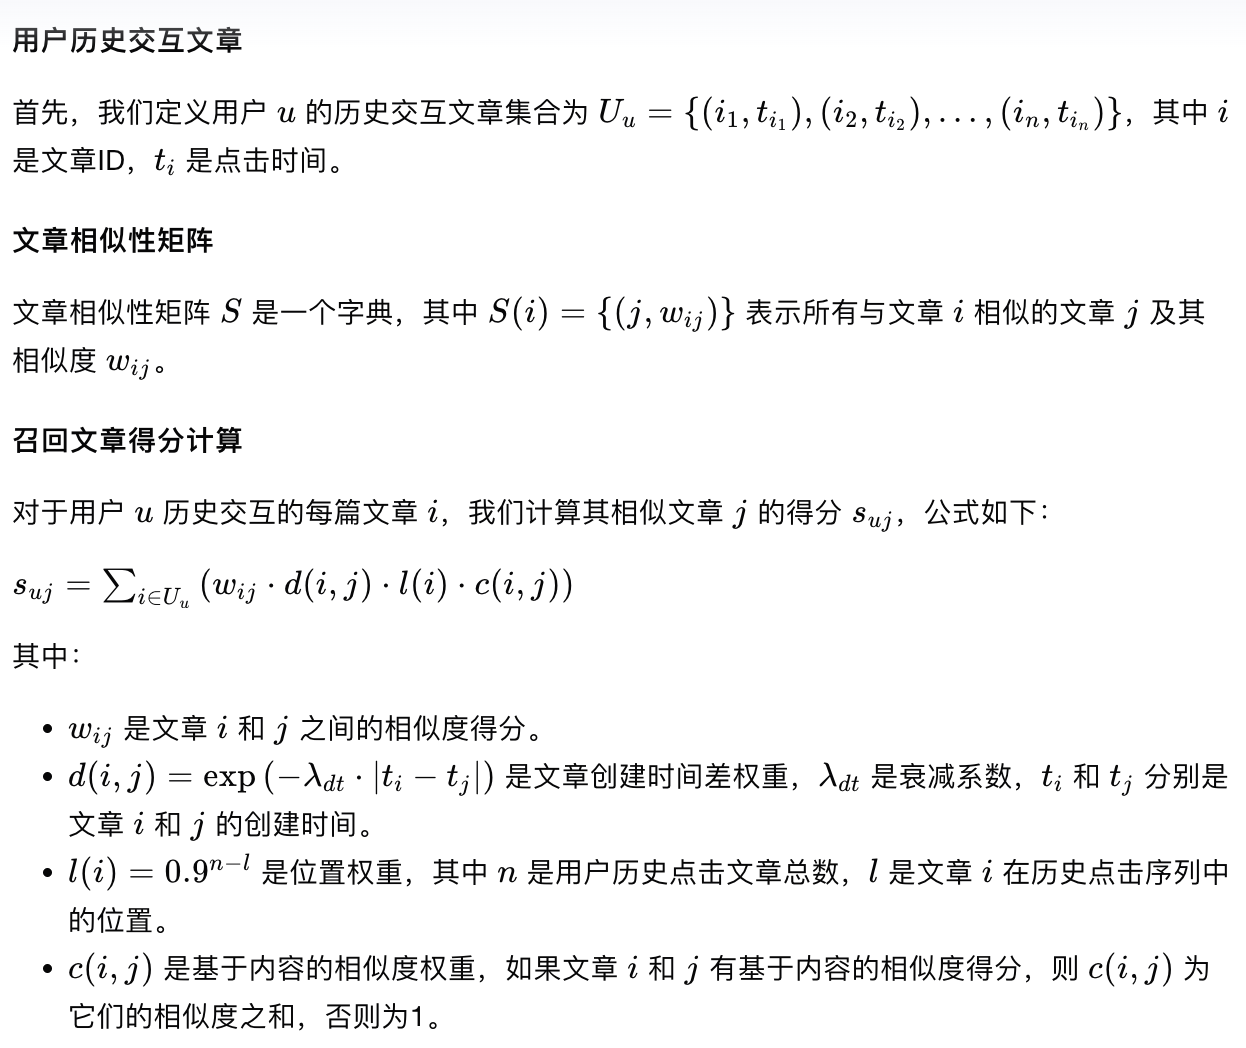

In [112]:
# 基于商品的召回i2i
def item_based_recommend(user_id,user_item_time_dict,i2i_sim,sim_item_topk,recall_item_num,item_topk_click,item_created_time_dict,emb_i2i_sim):
    """
        基于文章协同过滤的召回
        user_id: 用户id
        user_item_time_dict:字典，根据点击时间获取用户的点击文章序列 {user1:{item1:time1,item2:time2}}
        i2i_sim: 字典，文章相似性矩阵
        sim_item_topk: 整数，选择与当前文章最相似的前k篇文章
        recall_item_num: 整数，最后的召回文章数量
        item_topk_click: 列表，点击次数最多的文章列表，用于召回补全
        emb_i2i_sim: 字典，基于内容embedding计算的文章相似性矩阵
        
        return: 召回的文章列表 {item1:score1,item2:score2,...}
    """
    # 获取用户历史交互的文章
    user_hist_items=user_item_time_dict[user_id]
    
    item_rank={} # 初始化召回文章的得分字典
    
    # 遍历用户历史点击的文章，并记录每篇文章在历史点击序列中的位置
    for loc,(i,click_time) in enumerate(user_hist_items):
        # 从文章相似性矩阵i2i_sim中获取与当前文章i最相似的前sim_item_topk个文章
        for j,wij in sorted(i2i_sim[i].items(),key=lambda x:x[1],reverse=True)[:sim_item_topk]:
            # 对于每篇相似文章j，如果它不在用户的历史点击中，计算其得分
            if j in user_hist_items: # 用户历史交互的文章
                continue
            
            # 文章创建时间差权重（时间差越大，权重越小）
            created_time_weight=np.exp(0.8**np.abs(item_created_time_dict[i]-item_created_time_dict[j]))
            # 相似文章和历史点击文章序列中历史文章所在的位置权重（位置越靠前，权重越大）
            loc_weight=(0.9**(len(user_hist_items)-loc))
            
            content_weight=1.0 # 基于内容embedding的相似度得分
            # wij：文章i和j的相似度得分
            
            if emb_i2i_sim.get(i,{}).get(j,None) is not None:
                content_weight+=emb_i2i_sim[i][j]
            if emb_i2i_sim.get(j,{}).get(i,None) is not None:
                content_weight+=emb_i2i_sim[j][i]
            
            # 更新召回文章的得分
            item_rank.setdefault(j,0)
            item_rank[j]+=created_time_weight*loc_weight*content_weight*wij
    
    # 使用热门文章补全召回列表
    # 不足10个，用热门文章补全
    if len(item_rank)<recall_item_num:
        for i, item in enumerate(item_top_click):
            if item in item_rank.items(): 
                continue
            item_rank[item]=-i-100
            if len(item_rank)==recall_item_num:
                break
    
    # 对召回文章进行排序，按照得分进行降序排序，并返回得分最高的前recall_item_num篇文章
    item_rank=sorted(item_rank.items(),key=lambda x: x[1],reverse=True)[:recall_item_num]
    
    return item_rank

In [116]:
if metric_recall:
    trn_hist_click_df,trn_last_click_df=get_hist_and_last_click(all_click_df)
else:
    trn_hist_click_df=all_click_df
    
user_recall_items_dict=collections.defaultdict(dict)
user_item_time_dict=get_user_item_time(trn_hist_click_df)

i2i_sim=pickle.load(open(save_path+'itemcf_i2i_sim.pkl','rb'))
# emb_i2i_sim=pickle.load(open(save_path+'emb_i2i_sim.pkl','rb'))

for user in tqdm(trn_hist_click_df['user_id'].unique()):
    user_recall_items_dict[user]=item_based_recommend(user,user_item_time_dict,\
                                                      i2i_sim,sim_item_topk,recall_item_num,\
                                                      item_topk_click,item_created_time_dict,emb_i2i_sim)
user_multi_recall_dict['itemcf_sim_itemcf_recall']=user_recall_items_dict
pickle.dump(user_multi_recall_dict['itemcf_sim_itemcf_recall'],open(save_path+'itemcf_recall_dict.pkl','wb'))

if metric_recall:
    # 召回效果评估
    metric_recall(user_multi_recall_dict['itemcf_sim_itemcf_recall'],trn_last_click_df,topk=recall_item_num)
    

  0%|          | 0/500 [00:00<?, ?it/s]


NameError: name 'sim_item_topk' is not defined